# Notebook for optimizing nanorods segmentation




In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

Image used for testing has inhomogenous background. Nanoparticles have shape, which is difficult to detect.

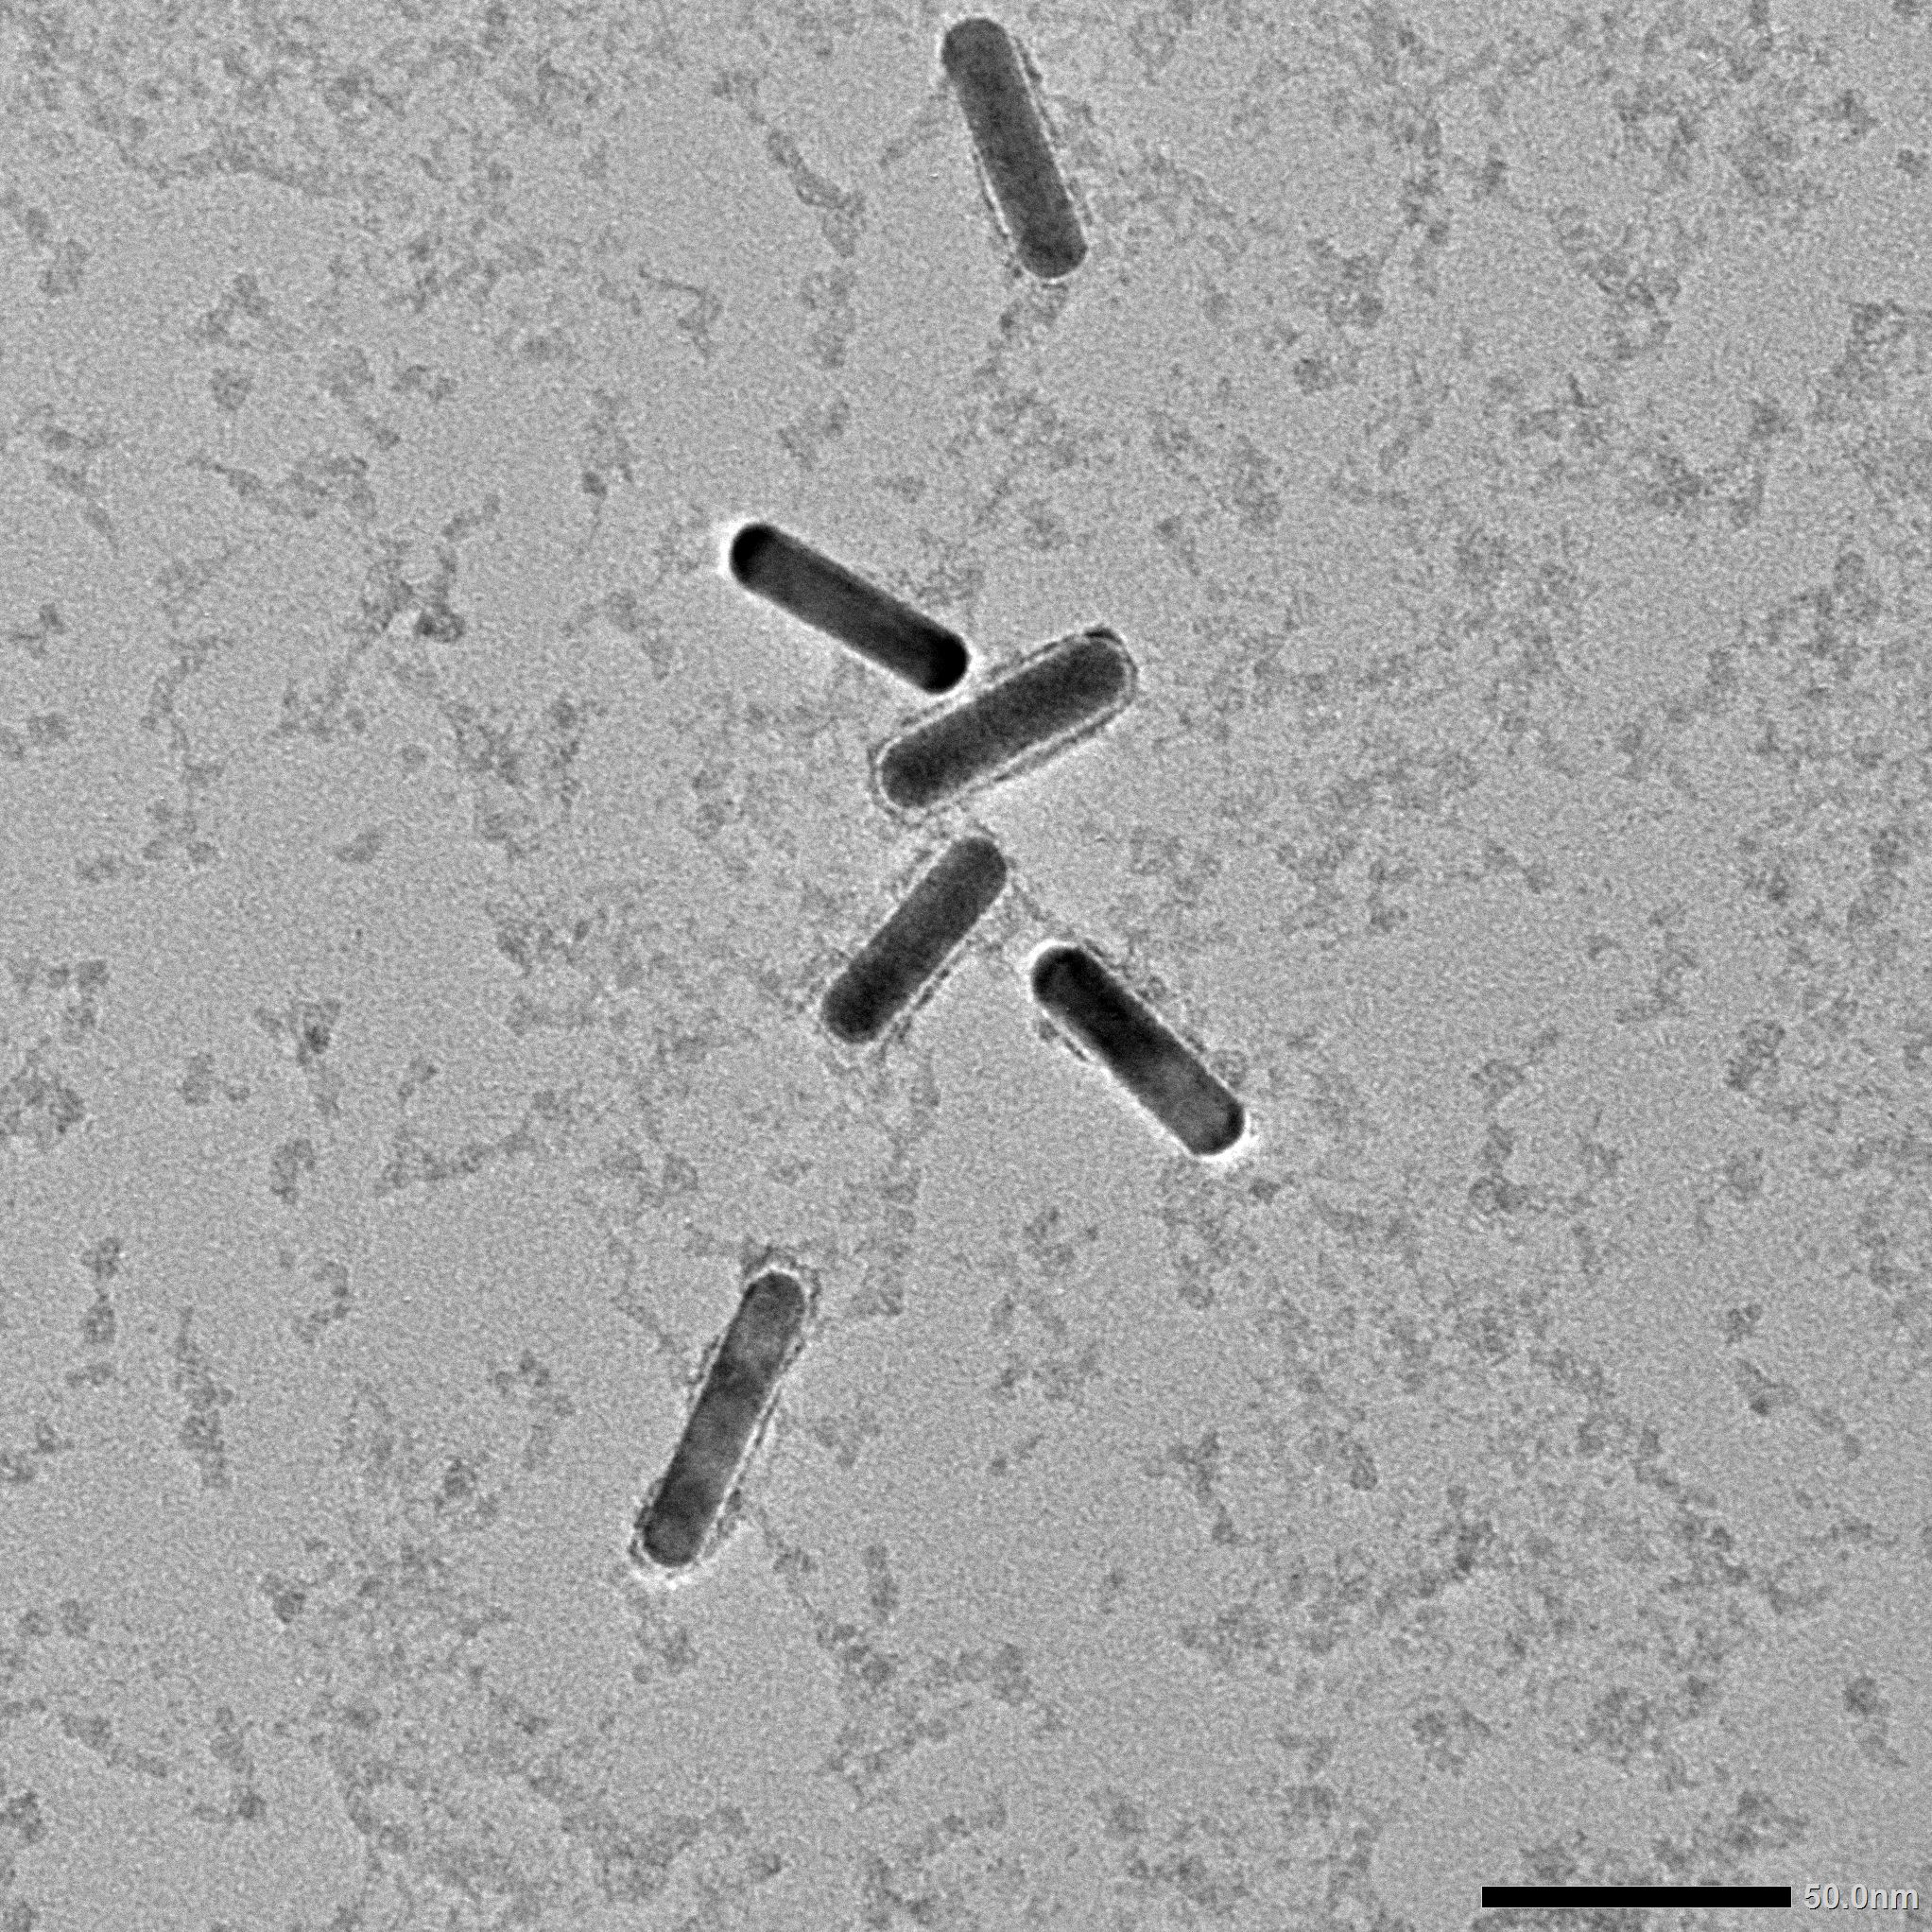

# Filtering and binarizing image

First I perform median filtering for removing noise. Then I binarize image and use morphological operations for cleaning image.

Goal is to create algorithm which can binarize image with inhomogenous background.

In [158]:
def filtering_img(img):    	
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    median = cv2.medianBlur(gray, 5)

    _, binary = cv2.threshold(median, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binary = 255 - binary

    kernel = np.ones((5,5),np.uint8)
    open = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, kernel, iterations=2)

    return close, gray

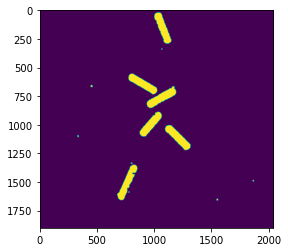

In [159]:
img = cv2.imread('/content/drive/MyDrive/fbmi/BP/A800AuNR_006.jpg')
img = img[:1900,:, :]

binary, gray = filtering_img(img)
plt.imshow(binary)

# Watershed segmentation

After having clear binary image, watershed segmentation can be performed. There is a problem with shape of nanorods and distance function. Watershed divides nanorods in half.

Goal is to crate algorithm which can perform watershed for nanoparticles well.

In [160]:
def distance(binary):
  kernel = np.ones((5,5),np.uint8)
  # sure background area
  sure_bg = cv2.dilate(binary, kernel, iterations=1)
  # Finding sure foreground area
  dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)

  return dist_transform, sure_fg, unknown

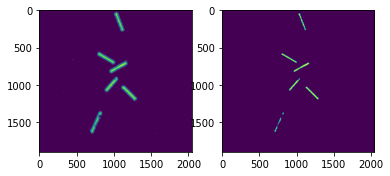

In [161]:
dist, fg, unknown = distance(binary)

plt.subplot(1, 2, 1)
plt.imshow(dist)

plt.subplot(1, 2, 2)
plt.imshow(fg)

In [162]:
def watershed_segmentation(img, fg, unknown):
  # Marker labelling
  _, markers = cv2.connectedComponents(fg)
  # Add one to all labels so that sure background is not 0, but 1
  markers = markers+1
  # Now, mark the region of unknown with zero
  markers[unknown==255] = 0

  markers = cv2.watershed(img, markers)
  img[markers == -1] = [255,0,0]

  return markers, img

Number of regions in image: 9


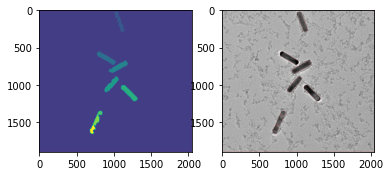

In [163]:
markers, img = watershed_segmentation(img, fg, unknown)

plt.subplot(1, 2, 1)
plt.imshow(markers)

plt.subplot(1, 2, 2)
plt.imshow(img)

print(f'Number of regions in image: {np.max(markers)-1}')

# Ellipse hough transform

Some images containg overlapping nanorods and watershed takes in accound only non overlapping areas, so approximation of areas of overlapping nanorods isn't accurate. So I try to implement elliptical hough transform.

The goal is to create algorithm which can perform elliptical hough transform in acceptable time.

In [164]:
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse, rescale
from skimage.draw import ellipse_perimeter

In [182]:
def elliptical_HT(gray, binary):
  gray = rescale(gray, 0.25)
  rgb = np.stack((gray, gray, gray), axis=2)
  print(rgb.shape)

  kernel = np.ones((5,5),np.uint8)
  dilate = cv2.dilate(binary, kernel, iterations=1)
  edges = binary - dilate

  # Perform a Hough Transform
  # The accuracy corresponds to the bin size of a major axis.
  # The value is chosen in order to get a single high accumulator.
  # The threshold eliminates low accumulators
  result = hough_ellipse(edges, accuracy=10, threshold=250, min_size=50, max_size=80)

  result.sort(order='accumulator')

  # Estimated parameters for the ellipse
  best = list(result[-1])
  yc, xc, a, b = [int(round(x)) for x in best[1:5]]
  orientation = best[5]

  # Draw the ellipse on the original image
  for yc, xc, a, b, orientation in result:
    cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
    rgb[cy, cx] = (0, 0, 255)
    # Draw the edge (white) and the resulting ellipse (red)
    edges = color.gray2rgb(img_as_ubyte(edges))
    edges[cy, cx] = (250, 0, 0)

  return rgb, edges

In [183]:
rgb, edges = elliptical_HT(gray, binary)

plt.subplot(1, 2, 1)
plt.imshow(rgb)

plt.subplot(1, 2, 2)
plt.imshow(edges)

(475, 511, 3)


KeyboardInterrupt: ignored